In [26]:
import torch
import torch.sparse
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [62]:
model = YOLO('models/yolo11x_trained_pruned_local_unstructured_10.pt')

In [14]:
import os

models={}

pathToModels="../cocoa_diseases_yolo11x_dense"

for n in os.listdir(pathToModels):
    model_name=n.strip("train_")
    for i in os.listdir(f"{pathToModels}/{n}"):
        if i=="weights":
            models[model_name]=f"{pathToModels}/{n}/{i}/best.py"
            
print(models)

{'dense': '../cocoa_diseases_yolo11x_dense/train_dense/weights/best.py', 'pruned_local_unstructured_20': '../cocoa_diseases_yolo11x_dense/train_pruned_local_unstructured_20/weights/best.py', 'pruned_local_structured_20_channel': '../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_20_channel/weights/best.py', 'pruned_local_structured_50_channel': '../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_50_channel/weights/best.py', 'pruned_local_structured_30_channel_mask': '../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_30_channel_mask/weights/best.py', 'pruned_local_structured_30_channel': '../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_30_channel/weights/best.py', 'pruned_local_structured_10_neuro': '../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_10_neuron/weights/best.py', 'pruned_local_structured_15_neuro': '../cocoa_diseases_yolo11x_dense/train_pruned_local_structured_15_neuron/weights/best.py', 'pruned_local_structured_

In [ ]:
import csv

with open("validation_results.csv","w", newline="") as file:
    
    writer=csv.writer(file)
    
    #write headers
    writer.writerow(["Model_name","mAP50","mAP50_95"])
    
    for key, value in models.items():
        
        model=YOLO(value)
        
        val = model.val(
        data="../datasets/cocoa_diseases/cocoa_dataset.yaml",
        name=f"val_{key}"
        imgsz=640,
        batch=4,  # Small batch size
        device=[0]  # GPU
        )
        
        
        mAP50=val.box.map50
        mAP50_95=val.box.map
        
        writer.writerow([key,mAP50,mAP50_95])
        

In [24]:
import csv


with open("test.csv","w", newline="") as file:
    writer=csv.writer(file)
    
    #write hearders
    writer.writerow(["Model name","mAP50","mAP50-95"])
    # mAP50=val.box.map50
    # mAP50_95=val.box.map
    
    for key,value in models.items():
        writer.writerow([key])

## Compute sparsity per model architecture component

In [63]:
import torch
import numpy as np

# Define the indices or ranges for backbone, neck, and head
backbone_range = range(0, 9)  # Layers 0-8 are backbone
neck_range = range(9, 23)     # Layers 9-22 are neck
head_range = range(23, len(model.model.model))  # Layers 23+ are head

# Initialize counters for zero weights and total weights
backbone_zero = 0
backbone_total = 0

neck_zero = 0
neck_total = 0

head_zero = 0
head_total = 0

# Iterate through the layers and collect weights into categories
for i, module in enumerate(model.modules()):  # Iterate over the components
    if isinstance(module, torch.nn.Conv2d):  # Ensure it's a Conv2D layer
        weights = module.weight.detach().cpu().numpy().flatten()  # Flatten the weights
        
        zero_count = np.sum(weights == 0)  # Count zero weights
        total_count = weights.size          # Total number of weights
        
        if i in backbone_range:
            backbone_zero += zero_count
            backbone_total += total_count
        elif i in neck_range:
            neck_zero += zero_count
            neck_total += total_count
        elif i in head_range:
            head_zero += zero_count
            head_total += total_count

# Calculate sparsity percentages
backbone_sparsity = (backbone_zero / backbone_total) * 100 if backbone_total > 0 else 0
neck_sparsity = (neck_zero / neck_total) * 100 if neck_total > 0 else 0
head_sparsity = (head_zero / head_total) * 100 if head_total > 0 else 0

# Display the sparsity results
print(f"Backbone Sparsity: {backbone_sparsity:.2f}% ({backbone_zero}/{backbone_total} weights are zero)")
print(f"Neck Sparsity: {neck_sparsity:.2f}% ({neck_zero}/{neck_total} weights are zero)")
print(f"Head Sparsity: {head_sparsity:.2f}% ({head_zero}/{head_total} weights are zero)")


Backbone Sparsity: 10.00% (16848/168480 weights are zero)
Neck Sparsity: 10.00% (20276/202752 weights are zero)
Head Sparsity: 0.00% (0/0 weights are zero)


## Some weight distribution visualizations (not so useful since values are really small)

Backbone weights collected: 168480
Neck weights collected: 202752
Head weights collected: 0


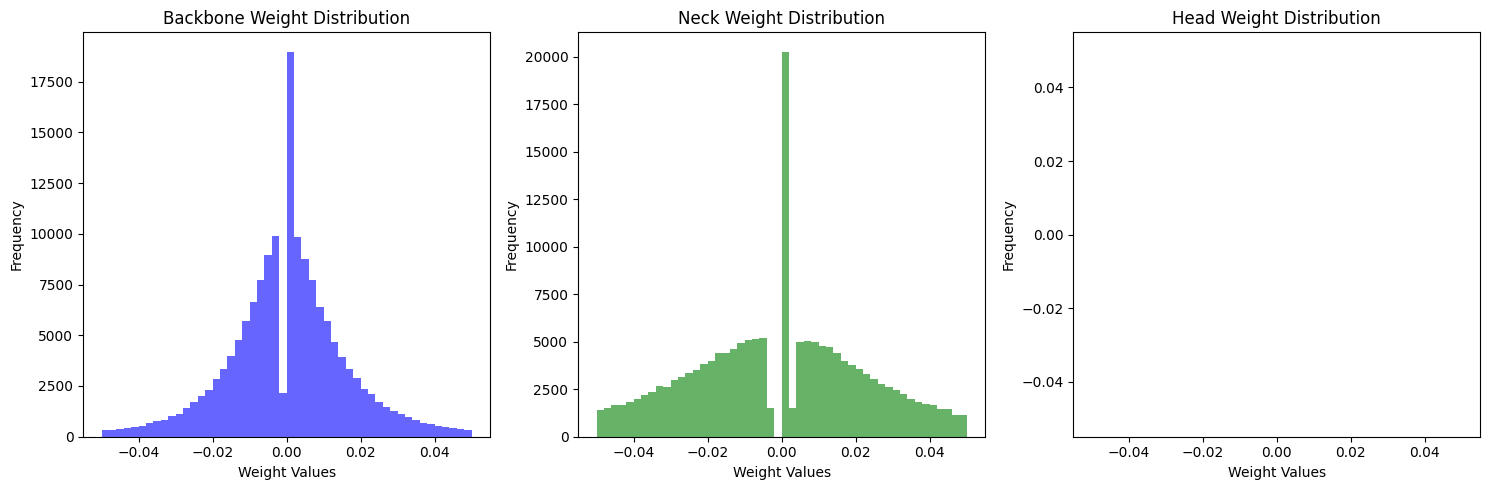

In [64]:
import matplotlib.pyplot as plt

# Define the indices or ranges for backbone, neck, and head
backbone_range = range(0, 9)  # Layers 0-8 are backbone
neck_range = range(9, 23)     # Layers 9-22 are neck
head_range = range(23, len(model.model.model))  # Layers 23+ are head

# Initialize storage for weights
backbone_weights = []
neck_weights = []
head_weights = []

# Iterate through the layers and collect weights into categories
for i, module in enumerate(model.modules()):  # Iterate over the components
    if isinstance(module, torch.nn.Conv2d):  # Ensure it's a Conv2D layer
        weights = module.weight.detach().cpu().numpy().flatten()
#        print(f"Layer {i}, weights collected: {weights.shape}")  # Debugging print
        if i in backbone_range:
            backbone_weights.extend(weights)  # Use extend to flatten into one list
        elif i in neck_range:
            neck_weights.extend(weights)
        elif i in head_range:
            head_weights.extend(weights)

# Check collected weights
print(f"Backbone weights collected: {len(backbone_weights)}")
print(f"Neck weights collected: {len(neck_weights)}")
print(f"Head weights collected: {len(head_weights)}")

# Plot the weight distributions for each category
plt.figure(figsize=(15, 5))

# Plot Backbone weights
plt.subplot(1, 3, 1)
plt.hist(backbone_weights, bins=50, range=(-0.05, 0.05), alpha=0.6, color='blue', label="Backbone")
plt.title("Backbone Weight Distribution")
plt.xlabel("Weight Values")
plt.ylabel("Frequency")

# Plot Neck weights
plt.subplot(1, 3, 2)
plt.hist(neck_weights, bins=50, range=(-0.05, 0.05), alpha=0.6, color='green', label="Neck")
plt.title("Neck Weight Distribution")
plt.xlabel("Weight Values")
plt.ylabel("Frequency")

# Plot Head weights
plt.subplot(1, 3, 3)
plt.hist(head_weights, bins=50, range=(-0.05, 0.05), alpha=0.6, color='red', label="Head")
plt.title("Head Weight Distribution")
plt.xlabel("Weight Values")
plt.ylabel("Frequency")

# Display the plot
plt.tight_layout()
plt.show()


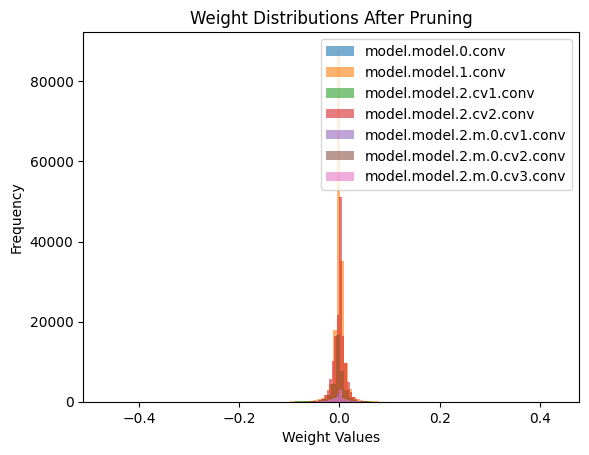

In [16]:
import matplotlib.pyplot as plt

# Plot weight distributions for different layers
for i, (name, module) in enumerate(model.named_modules()):
    if isinstance(module, torch.nn.Conv2d) and i<30:
        weights = module.weight.detach().cpu().numpy().flatten()
        plt.hist(weights, bins=50, alpha=0.6, label=name)

plt.title("Weight Distributions After Pruning")
plt.xlabel("Weight Values")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()